# Loading Packages

In [12]:
import os
import torch
from utils.visualize       import visualize_images_from_classes
from utils.datasets        import returnDataLoader, extract_selected_features, load_images_and_labels
from utils.model_execution import runFMA, runDLA, runKBA
from utils.analysis        import print_analysis

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


# Load Patches

In [ ]:
test = True

if(test):
    data_dir = './data'
    classes  = ['artifact_free', 'blur']

else:
    while True:
        data_dir = input("Please enter the dataset directory, for example: ./data/: ") or "./data/combined/"

        if not os.path.isdir(data_dir):
            print(f"Directory '{data_dir}' does not exist. Please try again.\n")
            continue
        print("\nDataset directory confirmed.\n")

        break

    classes            = []
    artifact_free      = input("Please enter the name of the artifact free folder (e.g., artifact_free): ").strip()
    artifact_free_path = os.path.join(data_dir, artifact_free)

    if artifact_free and os.path.isdir(artifact_free_path):
        classes.append(artifact_free)
        print(f"Folder '{artifact_free_path}' exists and was added as artifact free.")
    else:
        if artifact_free:
            print(f"Folder '{artifact_free_path}' does not exist. Please check the name.")

    artifact      = input("Please enter the name of the artifact folder (e.g., artifact): ").strip()
    artifact_path = os.path.join(data_dir, artifact)

    if artifact and os.path.isdir(artifact_path):
        classes.append(artifact)
        print(f"Folder '{artifact_path}' exists and was added as artifact.")
    else:
        if artifact:
            print(f"Folder '{artifact_path}' does not exist. Please check the name.")

    if classes:
        print("\nDataset loaded successfully.")
    else:
        print("\nNo valid class folders were provided. Defaulting to sample classes.")
        classes = ['artifact_free', 'blur']


# Random visualization of different classes

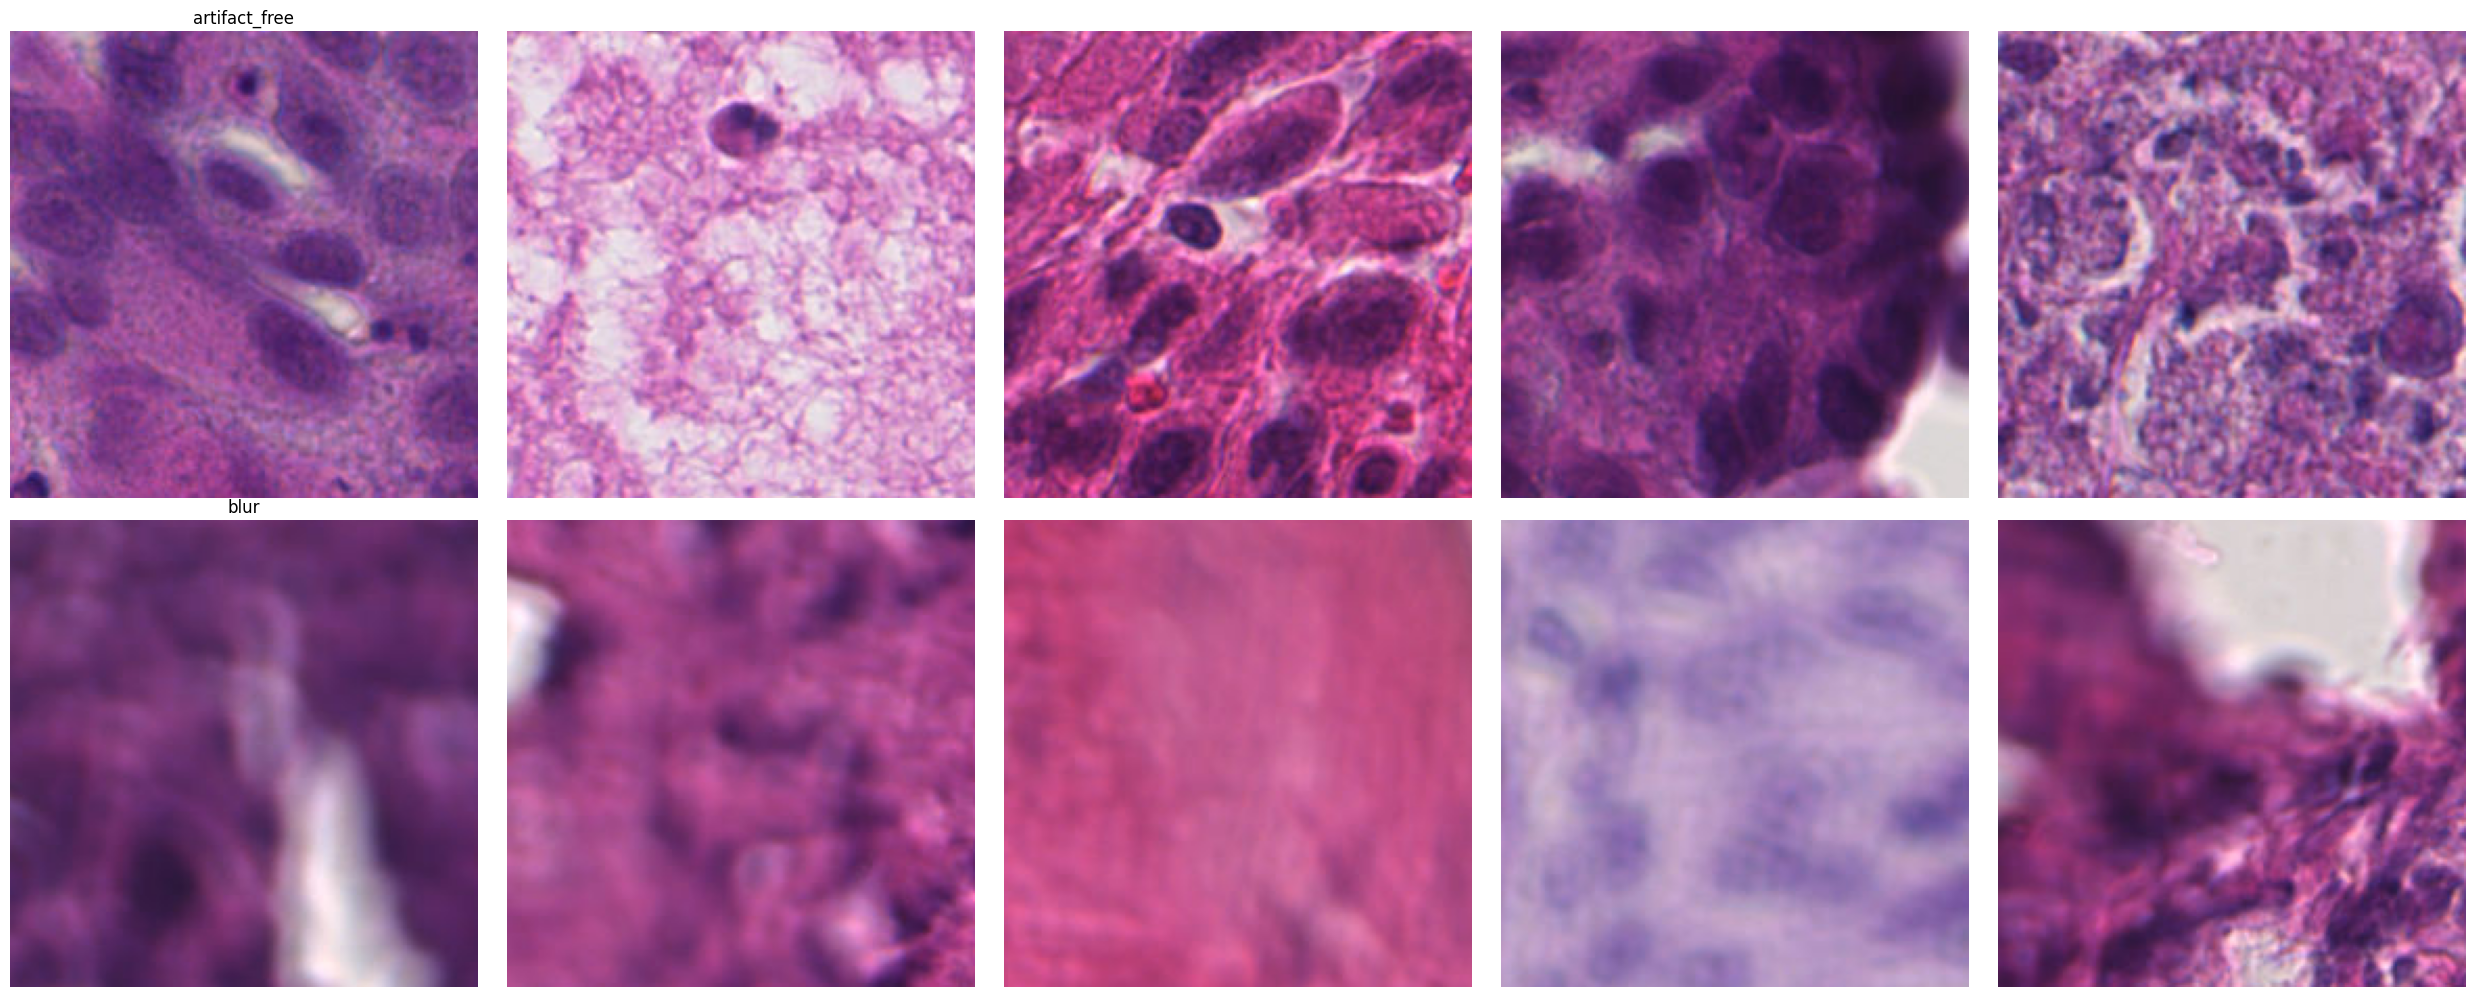

In [15]:
visualize_images_from_classes(data_dir, classes)

# Prepare data for classification

In [16]:
fma_dataloader = returnDataLoader(data_dir, classes, 32)
dla_dataloader = returnDataLoader(data_dir, classes, 128)

print("Total dataset size (samples): ", len(dla_dataloader.dataset))

Total dataset size (samples):  2102


In [17]:
X, y           = load_images_and_labels(data_dir, classes)

Loading 'blur': 100%|██████████| 1137/1137 [00:44<00:00, 25.66it/s]


In [18]:
X_feat, y_feat = extract_selected_features(X, y)

Extracting features: 100%|██████████| 2102/2102 [02:51<00:00, 12.22it/s]


# Classify images with different models

### FMA

In [19]:
runFMA(fma_dataloader, device, './models/fma_binary.pth')

Epoch 1 [test]: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]


### DLA

In [20]:
runDLA(dla_dataloader, device, './models/dla_binary.pth')

/home/alexander.webber/HistoART/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alexander.webber/HistoART/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 [test]: 100%|██████████| 17/17 [00:08<00:00,  1.94it/s]


### KBA

In [21]:
runKBA(X_feat, y_feat, './models/kba_binary.pkl')

/home/alexander.webber/HistoART/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alexander.webber/HistoART/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alexander.webber/HistoART/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.

Predictions saved to './results/kba_results.csv'.


# Analysis

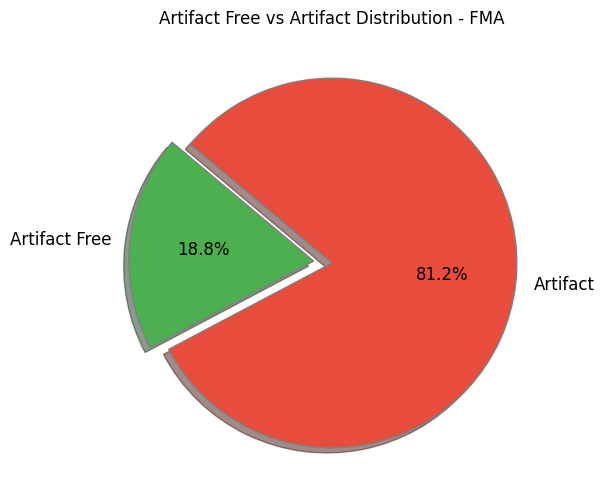

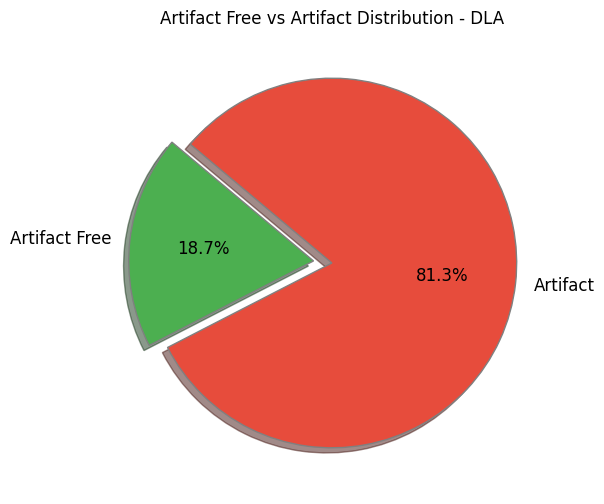

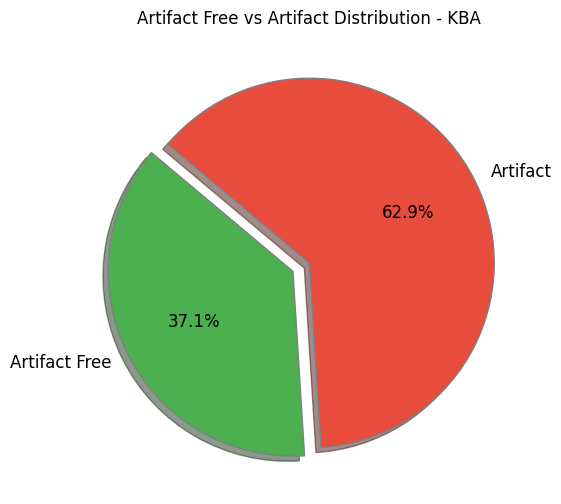

In [22]:
print_analysis('./results/fma/fma_binary_external_tcga.csv', "FMA")
print_analysis('./results/dla/dla_binary_external_tcga.csv', "DLA")
print_analysis('./results/kba/kba_binary_external_tcga.csv', "KBA")